# Part 1
In the following cell, modules from standard libraries are imported. We also define several functions for (1) implementing landmark selection techniques (the proposed importance sampling method and related work) and (2) generating low-rank Nystrom approximations. 

In [1]:
#  allows you to bring all the functions, classes, and variables defined in the "utils" module into the current namespace.
from utils import *

# Part 2
In the following cell, we load sick_euthyroid data and compute the original kernel matrix and its best rank-r approximation as a baseline.

In [2]:
# Importing the necessary modules and fetching the dataset
# Dataa contains multiple datasets, we are selecting the 'ozone_level' dataset for analysis
Dataa = fetch_datasets(filter_data=(24, "ozone_level"))

# Extracting the dataset and preprocessing the data
m1 = []
m2 = []
for i, j in Dataa.items():
    m1.append(i)
    m2.append(j)
dataset = m2[0]  # Selecting the first dataset ('ozone_level')
X = dataset['data']  # Feature matrix
y = dataset['target']  # Target labels

# Preprocess the data using MinMaxScaler to scale the features to the [0, 1] range
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

print("size of input data and target: ", X.shape, y.shape)  # Display the size of input data and target

# Calculate the kernel bandwidth parameter sigma using the beta value (set to 2 in this case)
beta = 2
DistMatrix = euclidean_distances(X, squared=True)  # Calculate the squared Euclidean distance matrix
sigma = beta * np.sqrt(np.sum(DistMatrix, axis=(0, 1)) / (len(DistMatrix) ** 2 - len(DistMatrix)))

# Form the kernel matrix K_org using the Gaussian kernel function
K_org = np.exp(-DistMatrix / (sigma ** 2))
K_org = (K_org + K_org.T) / 2  # Ensure symmetry of the kernel matrix
K_org_frob_norm = la.norm(K_org)  # Frobenius norm of the kernel matrix

# Perform Singular Value Decomposition (SVD) of the kernel matrix to get low-rank approximation
EigVec, EigVal, _ = la.svd(K_org)
max_eig = EigVal[0]  # Maximum eigenvalue of the kernel matrix

# Choose the rank for low-rank approximation
r = 2

# Obtain the r-largest eigenvectors and corresponding eigenvalues for low-rank approximation
EigVec_r = EigVec[:, 0:r]
EigVal_r = EigVal[0:r]

# Calculate and display the best approximation error for the chosen rank-r approximation
best_approx_norm = la.norm(K_org - la.multi_dot([EigVec_r, np.diag(EigVal_r), EigVec_r.T])) / K_org_frob_norm
print("Best approximation error: ", best_approx_norm)


size of input data and target:  (2536, 72) (2536,)
Best approximation error:  0.04143954156639246


In [3]:
sigma

4.569853785859607

# Part 3

In the following cell, various landmark selection techniques are compared in terms of accuracy and running time.

These comments describe a loop that runs experiments for different landmark selection methods and stores the results (approximation errors and computation times) in DataFrames. The loop iterates over the values of m (number of landmarks) and performs multiple trials for each method. The results are then stored in DataFrames with appropriate column names for later analysis and comparison.

In [4]:
# Specify the values of m (number of landmarks) to be evaluated
m_all = r * np.array([2, 5])

# Number of trials for each experiment
n_trial = 50

# Iterate over each m value and store the results
for index in np.arange(2):
    m = m_all[index]
    print(m)  # Display the current value of m
    # Create DataFrames to store errors and times for each landmark selection method
    globals()["results_error_m" + str(m)] = pd.DataFrame(-1 * np.ones((n_trial, 5)), columns=['uniform', 'kmeans', 'dpp', 'imp_v1', 'imp_v2'])
    globals()["results_time_m" + str(m)] = pd.DataFrame(-1 * np.ones((n_trial, 5)), columns=['uniform', 'kmeans', 'dpp', 'imp_v1', 'imp_v2'])

    # Initialize arrays to store errors and times for each trial
    err_uni = -1 * np.ones(n_trial)
    err_kmeans = -1 * np.ones(n_trial)
    err_dpp = -1 * np.ones(n_trial)
    err_imp1 = -1 * np.ones(n_trial)
    err_imp2 = -1 * np.ones(n_trial)

    time_uni = -1 * np.ones(n_trial)
    time_kmeans = -1 * np.ones(n_trial)
    time_dpp = -1 * np.ones(n_trial)
    time_imp1 = -1 * np.ones(n_trial)
    time_imp2 = -1 * np.ones(n_trial)

    # Run experiments for the current m value
    for exper in np.arange(n_trial):
        # Uniform landmark selection
        start = time.time()
        Z_uni = landmark_uniform(X, m)
        EigVec_uni, EigVal_uni = nystrom(X, Z_uni, sigma, r)
        time_uni[exper] = time.time() - start
        err_uni[exper] = la.norm(K_org - la.multi_dot([EigVec_uni, np.diag(EigVal_uni), EigVec_uni.T])) / K_org_frob_norm

        # K-means landmark selection
        start = time.time()
        Z_kmeans = landmark_kmeans(X, m)
        EigVec_kmeans, EigVal_kmeans = nystrom(X, Z_kmeans, sigma, r)
        time_kmeans[exper] = time.time() - start
        err_kmeans[exper] = la.norm(K_org - la.multi_dot([EigVec_kmeans, np.diag(EigVal_kmeans), EigVec_kmeans.T])) / K_org_frob_norm

        # DPP landmark selection
        start = time.time()
        Z_dpp = landmark_dpp(K_org, X, max_eig, m)
        if la.norm(Z_dpp - np.ones((m, X.shape[1]))) != 0:
            EigVec_dpp, EigVal_dpp = nystrom(X, Z_dpp, sigma, r)
            time_dpp[exper] = time.time() - start
            err_dpp[exper] = la.norm(K_org - la.multi_dot([EigVec_dpp, np.diag(EigVal_dpp), EigVec_dpp.T])) / K_org_frob_norm

        # Importance sampling landmark selection (alpha=0.5)
        start = time.time()
        Z_imp = landmark_importanceSampling(X, sigma, m, frac=0.1, alpha=0.5)
        EigVec_imp, EigVal_imp = nystrom(X, Z_imp, sigma, r)
        time_imp1[exper] = time.time() - start
        err_imp1[exper] = la.norm(K_org - la.multi_dot([EigVec_imp, np.diag(EigVal_imp), EigVec_imp.T])) / K_org_frob_norm

        # Importance sampling landmark selection (alpha=1)
        start = time.time()
        Z_imp = landmark_importanceSampling(X, sigma, m, frac=0.1, alpha=1)
        EigVec_imp, EigVal_imp = nystrom(X, Z_imp, sigma, r)
        time_imp2[exper] = time.time() - start
        err_imp2[exper] = la.norm(K_org - la.multi_dot([EigVec_imp, np.diag(EigVal_imp), EigVec_imp.T])) / K_org_frob_norm

    # Store the results in the respective DataFrames
    globals()["results_error_m" + str(m)]["uniform"] = err_uni
    globals()["results_error_m" + str(m)]["kmeans"] = err_kmeans
    globals()["results_error_m" + str(m)]["dpp"] = err_dpp
    globals()["results_error_m" + str(m)]["imp_v1"] = err_imp1
    globals()["results_error_m" + str(m)]["imp_v2"] = err_imp2

    globals()["results_time_m" + str(m)]["uniform"] = time_uni
    globals()["results_time_m" + str(m)]["kmeans"] = time_kmeans
    globals()["results_time_m" + str(m)]["dpp"] = time_dpp
    globals()["results_time_m" + str(m)]["imp_v1"] = time_imp1
    globals()["results_time_m" + str(m)]["imp_v2"] = time_imp2


4
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel comp

L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel comput

# Part 4
We plot the approximation quality and running time. 

These comments explain how to create a subplot with two horizontal boxplots side by side. The first boxplot shows the results for m=4, while the second boxplot shows the results for m=10. The results_error_m4 DataFrame is used for the first plot, and the results_error_m10 DataFrame (excluding the 'dpp' column) is used for the second plot. The boxplots are colored using the 'coolwarm' palette to visualize the distribution of approximation errors for each landmark selection method.

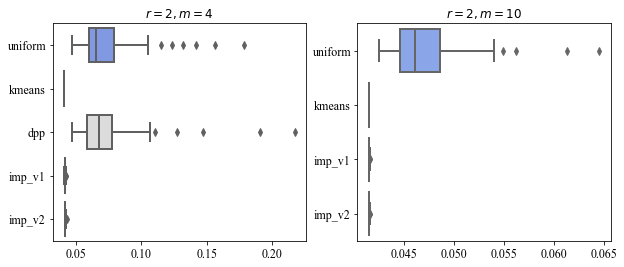

In [5]:
# Create a subplot with two horizontal axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first boxplot with title and data for m=4
axes[0].set_title("$r=2, m=4$")
sns.boxplot(data=results_error_m4, orient="h", palette="coolwarm", ax=axes[0])

# Plot the second boxplot with title and data for m=10 (excluding 'dpp' method)
axes[1].set_title("$r=2, m=10$")
sns.boxplot(data=results_error_m10.loc[:, results_error_m10.columns != 'dpp'], orient="h", palette="coolwarm", ax=axes[1])

In [6]:
results_time_m4.mean(), results_time_m10.mean()

(uniform    0.001659
 kmeans     0.211273
 dpp        3.907791
 imp_v1     0.025587
 imp_v2     0.025783
 dtype: float64, uniform    0.003291
 kmeans     0.369473
 dpp       -1.000000
 imp_v1     0.043220
 imp_v2     0.042995
 dtype: float64)